# Querying a track with SQL-like commands


With ``Tracklib`` it is really easy and convenient to "query" a track with SQL-like commands. The output take the type of a n-dimensional array, a new track or quite simply a float value.

To query a track, you have to write a text command in a language which strongly similar at SQL, and call the function ``query`` by passing the text as argument.

For example, the query below, create a new *track* with only observations whose speed is under 0.5 m/s:

<div class="alert alert-block alert-success" style="padding-left:4em">
queryTxt  = ' SELECT * WHERE speed < 0.5 '
    
track2 = track.query(queryTxt)</div>
        
Note that the syntax is inspired by SQL, but is a little more restrictive.

## Let's start by defining our environment

1. The first task is only useful for the online notebook, we specify a new value of the PATH environment variable, the directory of *tracklib* library.

In [1]:
import os
import sys

# Import de tracklib
module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

2. Then, let's importing all necessary python library including *Tracklib* :

In [2]:
# Import de la librairie tracklib
import tracklib as trk

# And others 
import matplotlib.pyplot as plt

code running in a no qgis environment
code running in a no qgis environment


## Loading a track for examples

After loading the track, we add 3 analytical features (speed, heading and direction) to filter observation according to these criteria:

In [3]:
# Load a track
trk.ObsTime.setReadFormat("4Y-2M-2DT2h:2m:2sZ")
tracks = trk.TrackReader.readFromGpx('../../../data/gpx/activity_5807084803.gpx')
trace = tracks.getTrack(0)
trace.toENUCoords()
trace.summary()

# Start AF computation
trace.addAnalyticalFeature(trk.speed)
trace.addAnalyticalFeature(trk.heading)
trace.addAnalyticalFeature(trk.orientation)

# Display available AFs for the track
print (trace.getListAnalyticalFeatures())

-------------------------------------
GPS track #activity_5807084803 of user 0:
-------------------------------------
  Nb of pt(s):   190
  Ref sys id   : ENU
  Starting at  : 11/11/2020 15:39:54
  Ending at    : 11/11/2020 15:52:00
  Duration     : 726.000 s
  Length       : 2412.144 m
-------------------------------------

['speed', 'heading', 'orientation']


## General rules for querying track

- The request will be written using SQL-like commands.
- Only *SELECT* and *WHERE* clauses are available
- SELECT is mandatory and WHERE is optional
- Blank space must be used between every other words, symbols and operators
- Capital letters must be used for SQL keywords SELECT, WHERE, AND, OR and aggregators 

**Fields**

- All analytical features, x, y, z, t, and timestamp are available as fields
- Fields are written without quotes. They must not contain blank spaces
- "t" is time as integer in seconds since 1970/01/01 00:00:00
- "timestamp" is ObsTime object

**Aggregators**

- All unary operators described in Operator.py, except MSE, are available. For now we have: SUM, AVG, VAR, COUNT, MEDIAN, ARGMIN, ARGMAX, MIN, MAX, MAD, RMSE, SEDDEV, ZEROS.

##  ``SELECT`` clause

Like SQL language, output depends on the select clause. 

### You get a new ``Track``

If SELECT clause is followed by as star, output is a copied track of the original track (with all its AF hopefully)

In [4]:
trace1 = trace.query("SELECT *")
trace1.summary()

-------------------------------------
GPS track #0 of user 0:
-------------------------------------
  Nb of pt(s):   190
  Ref sys id   : ENU
  Starting at  : 11/11/2020 15:39:54
  Ending at    : 11/11/2020 15:52:00
  Duration     : 726.000 s
  Length       : 2412.144 m
-------------------------------------
Analytical feature(s):
 - speed
 - heading
 - orientation
-------------------------------------



### You get a (p x n)-dimensional array 

If SELECT clause is followed by a list of AF names like **SELECT f1, f2... fp**, then output is a (p x n)-dimensional array, with p = number of fields queried and n = number of observations selected by the WHERE conditions:

OUTPUT[i][j] = f*i* for the j-th observation

Speed for Obs(0): 6.255327113366183 Heading for Obs(0): -0.17391457626112597


Text(0.5, 1.0, 'heading for speed >= 5')

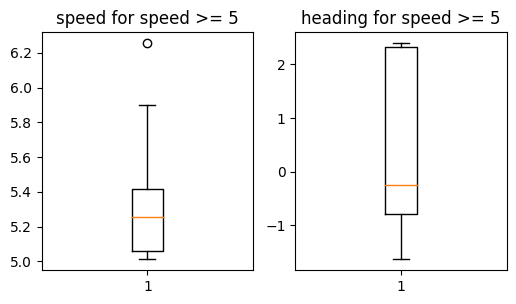

In [5]:
tab = trace.query("SELECT speed, heading WHERE speed >= 5")
print ('Speed for Obs(0):', tab[0][0], 'Heading for Obs(0):', tab[1][0])

# ======================================================================
#    Display a boxplot for all dimension of the result
plt.figure(figsize=(6, 2))
plt.subplots_adjust(top=1.3, wspace=0.2, hspace=0.2)

# Dimension speed
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax1.boxplot(tab[0])
ax1.set_title('speed for speed >= 5')

# Dimension heading
ax2 = plt.subplot2grid((1, 2), (0, 1))
ax2.boxplot(tab[1])
ax2.set_title('heading for speed >= 5')

### You get a (1-p)-dimensional array

If "SELECT AGG1(f1), AGG2(f2)... AGGp(fp)", with AGG1, AGG2,.. AGGp, a set of p aggregators, 
then output is a p-dimensional array, with on value for each aggregator

Note that operators take as input only analytical feature names. Therefore, "SELECT COUNT(*)" syntax 
is not allowed and must be replaced equivalently by "SELECT COUNT(f)" with any AF name f.

In [6]:
queryTxt  = " SELECT COUNT(speed), AVG(speed) "
queryTxt += " WHERE orientation = 1 "
    
values = trace.query(queryTxt)
print (values)

[14, 3.1897129536707767]


### You get a Float value

If "SELECT AGG(f)", then output is the floating point value returned by the operator.

In [7]:
value = trace.query("SELECT AVG(speed)")
print (value)

3.696302107811199


##  ``WHERE`` clause

WHERE clause may contain as many conditions as needed, separated by OR/AND key words

Parenthesis are not allowed within WHERE clause. Use boolean algebra rules to reformulate query without parenthesis: e.g. A AND (B OR C) = A AND B OR A AND C. Or use successive queries.

Each condition must contain exactly 3 parts (separated by blank spaces) in this exact order:
	(1) the name of an analytical feature to test
	(2) a comparison operator among >, <, >=, <=, ==, != and LIKE (with % in str and timestamps)
	(3) a threshold value which is automatically casted to the type of the AF given in (1). Intended types accepted are: integers, floats, strings, boolean and GPSTime. When ObsTime is used as a threshold value, eventhough it may contain 2 parts (date and time), it must not be enclosed within quotes. For boolean, "1", "T" and "TRUE" are considered as logical True, all other values are considered as False. 

Important: no computation allowed in WHERE conditions. E.g. "... WHERE z-2 > 10" not allowed

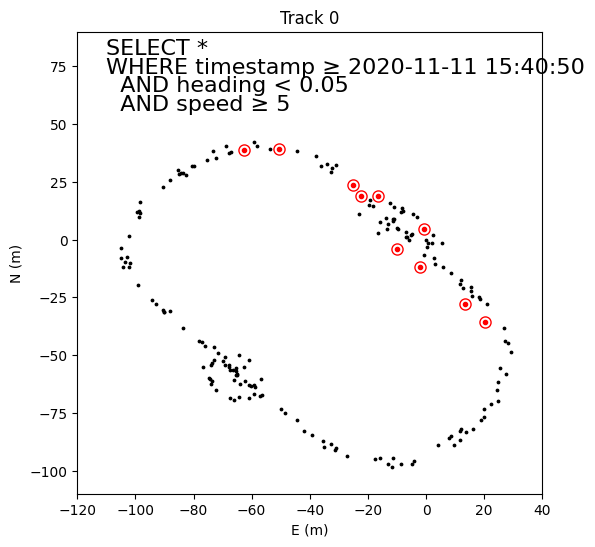

In [8]:
query  = " SELECT * "
query += " WHERE timestamp >= 2020-11-11 15:39:50 "  
query += "   AND heading < 0.05 "
query += "   AND speed >= 5 "
traceRapide = trace.query(query)

plt.figure(figsize=(6, 6))
trace.plot('ko', pointsize=3, append=True)
traceRapide.plotAsMarkers(type=trk.MARKERS_TYPE_SPOT, append=True)

plt.xlim([-120, 40])
plt.ylim([-110, 90])
plt.text(-110, 80, 'SELECT *', size=16)
plt.text(-110, 72, 'WHERE timestamp ≥ 2020-11-11 15:40:50', size=16)
plt.text(-110, 64, '  AND heading < 0.05 ', size=16)
plt.text(-110, 56, '  AND speed ≥ 5', size=16)
plt.show()